In [7]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Clock-D19-EPM/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
c19_epm_file = "/work/mk423/Clock-D19-EPM/Headstage_Tracked_C19_EPM_Data.pkl"
proj_file = PROJECT_PATH + "headstage_tracked_c19_epm_projection.csv"
bxcx_proj_file = PROJECT_PATH + "headstage_tracked_bxcx_c19_epm_projection.csv"

mean_file = PROJECT_PATH + "compheadstage_tracked_epm_mean_scores.csv"
bxcx_mean_file = PROJECT_PATH + "headstage_tracked_bxcx_c19_epm_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_psd','X_coh','X_gc']
FEATURE_WEIGHT = [10,1,1]

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list


In [8]:
dataDict = pickle.load(open(c19_epm_file,"rb"))

X = np.hstack([weight*dataDict[feature] for weight,feature in zip(FEATURE_WEIGHT,FEATURE_LIST)])
y_time = dataDict['y_time']
y_mouse = np.array(dataDict['y_mouse'])
y_condition = np.array(dataDict['y_condition'])
y_task = dataDict['y_task']
y_roi = dataDict["y_roi"]
y_expDate = dataDict['y_expDate']
s = model.project(X)

In [9]:
np.unique(y_mouse).shape

(21,)

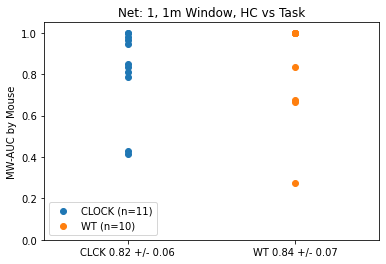

CLOCK Data Points [0.4166666666666667, 0.9666666666666667, 0.42857142857142855, 0.9444444444444444, 0.7857142857142857, 0.8125, 0.9777777777777777, 0.8472222222222222, 0.8333333333333334, 1.0, 1.0]
WT Data Points [1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.6727272727272727, 0.2727272727272727, 0.8333333333333334, 1.0]


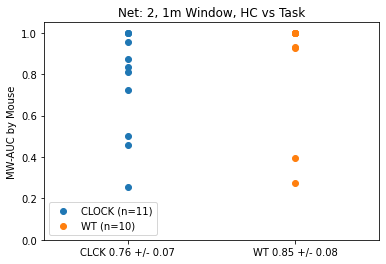

CLOCK Data Points [0.4583333333333333, 1.0, 0.2571428571428571, 0.7222222222222222, 0.5, 0.8125, 0.9555555555555556, 0.875, 0.8333333333333334, 1.0, 1.0]
WT Data Points [1.0, 1.0, 0.3939393939393939, 0.9259259259259259, 1.0, 1.0, 1.0, 0.2727272727272727, 0.9333333333333333, 1.0]


In [11]:

for net in range(2):
    auc_list = []
    auc_list_WT = []
    for mouse in np.unique(y_mouse):
        #print(mouse)
        mouse_mask = y_mouse==mouse

        s_mouse = s[mouse_mask==1,net]
        y_task_mouse = y_task[mouse_mask==1]
        y_cond_mouse = y_condition[mouse_mask==1][0]
        
        
        temp_s = s_mouse[:-int(s_mouse.shape[0]%60)].reshape(-1,60)
        temp_y = y_task_mouse[:-int(y_task_mouse.shape[0]%60)].reshape(-1,60)

        temp_s = np.mean(temp_s,axis=1)
        temp_y = np.mean(temp_y,axis=1) > 0.5
        auc, pval = model.mw_auc(temp_s,temp_y)

        if y_cond_mouse=="CLOCK":
            auc_list.append(auc)
        else:
            auc_list_WT.append(auc)

    plt.scatter(np.ones(len(auc_list)),auc_list,label="CLOCK (n={})".format(len(auc_list)))
    plt.scatter(np.ones(len(auc_list_WT))*2,auc_list_WT,label="WT (n={})".format(len(auc_list_WT)))
    
    plt.title("Net: {}, 1m Window, HC vs Task".format(net+1))
    plt.ylim([0,1.05])
    plt.xlim([0.5,2.5])
    plt.xticks([1,2],["CLCK {:.2f} +/- {:.2f}".format(np.mean(auc_list),np.std(auc_list)/np.sqrt(len(auc_list))),"WT {:.2f} +/- {:.2f}".format(np.mean(auc_list_WT),np.std(auc_list_WT)/np.sqrt(len(auc_list_WT)))])
    plt.ylabel("MW-AUC by Mouse")
    plt.legend()
    plt.show()
            
    print("CLOCK Data Points",auc_list)
    print("WT Data Points",auc_list_WT)
        
        

In [12]:
c19_mask = y_condition=="CLOCK"
wt_mask = y_condition=="WT"


c19_vs_wt = model.score(X,
                        wt_mask,
                       )

c19_vs_wt_hc = model.score(X[y_task==0],
                        wt_mask[y_task==0],
                       )

c19_vs_wt_task = model.score(X[y_task==1],
                        wt_mask[y_task==1],
                       )
c19_hc_v_task_auc = model.score(X[c19_mask==1],
                                y_task[c19_mask==1],
                                y_mouse[c19_mask==1],
                                return_dict=True)

c19_hc_v_task_auc_list = [c19_hc_v_task_auc[key] for key in c19_hc_v_task_auc.keys()
                          if not np.isnan(c19_hc_v_task_auc[key])]

c19_hc_v_task_mean = np.mean(c19_hc_v_task_auc_list)
c19_hc_v_task_sterr = np.std(c19_hc_v_task_auc_list) / np.sqrt(len(c19_hc_v_task_auc_list))

wt_hc_v_task_auc = model.score(X[wt_mask==1],
                                y_task[wt_mask==1],
                                y_mouse[wt_mask==1],
                                return_dict=True)

wt_hc_v_task_auc_list = [wt_hc_v_task_auc[key] for key in wt_hc_v_task_auc.keys() 
                         if not np.isnan(wt_hc_v_task_auc[key])]

wt_hc_v_task_mean = np.mean(wt_hc_v_task_auc_list)
wt_hc_v_task_sterr = np.std(wt_hc_v_task_auc_list) / np.sqrt(len(wt_hc_v_task_auc_list))

print("C19 HC vs Task {:.3f} +/- {:.3f} (n={})".format(c19_hc_v_task_mean,c19_hc_v_task_sterr,
                                               len(c19_hc_v_task_auc_list)))

print("WT HC vs Task {:.3f} +/- {:.3f} (n={})".format(wt_hc_v_task_mean,wt_hc_v_task_sterr,
                                               len(wt_hc_v_task_auc_list)))

print("Homecage wt vs c19: ",c19_vs_wt_hc)
print("Task wt vs c19: ",c19_vs_wt_task)
print("Overall wt vs c19: ",c19_vs_wt)

C19 HC vs Task 0.601 +/- 0.039 (n=11)
WT HC vs Task 0.644 +/- 0.036 (n=10)
Homecage wt vs c19:  0.5596742592003427
Task wt vs c19:  0.5817123510931665
Overall wt vs c19:  0.5720096862898502


In [13]:
c19_hc_v_task_3_net = get_3_net_aucs(s[c19_mask==1],y_task[c19_mask==1],y_mouse[c19_mask==1])
wt_hc_v_task_3_net = get_3_net_aucs(s[wt_mask==1],y_task[wt_mask==1],y_mouse[wt_mask==1])
hc_wt_vs_c19_3_net = get_3_net_aucs(s[y_task==0],wt_mask[y_task==0])
task_wt_vs_c19_3_net = get_3_net_aucs(s[y_task==1],wt_mask[y_task==1])

print("c19 hc vs task (means,stderr) ",c19_hc_v_task_3_net)
print("wt hc vs task (means,stderr) ",wt_hc_v_task_3_net)
print("hc wt vs c19 (means,stderr) ",hc_wt_vs_c19_3_net)
print("task wt vs c19 (means,stderr) ",task_wt_vs_c19_3_net)

c19 hc vs task (means,stderr)  ([0.6143928680649428, 0.5917106109852188, 0.5431092645170646], [0.042216539467543106, 0.03602639698483231, 0.0251617261682079])
wt hc vs task (means,stderr)  ([0.6520332646981012, 0.6319730699969799, 0.5357475880091354], [0.0376258422039047, 0.031419127932889264, 0.026176282368589338])
hc wt vs c19 (means,stderr)  ([0.5756846510280003, 0.5493692138561902, 0.418937129285172], [0.0, 0.0, 0.0])
task wt vs c19 (means,stderr)  ([0.5908164803893925, 0.5743979834460196, 0.3948560275646371], [0.0, 0.0, 0.0])


In [15]:
all_hc_v_task_aucs = model.score(X,y_task,y_mouse,return_dict=True)
all_hc_v_task_aucs_3_net = get_3_net_auc_dict(s,y_task,y_mouse)
coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())
agg_score = s[:,:3] @ coeffs

results_dict = {
    "agg score":agg_score,
    "net 1 scores":s[:,0],
    "net 2 scores":s[:,1],
    "net 3 scores":s[:,2],
    "mouse":y_mouse,
    "roi":y_roi,
    "condition":y_condition,
    "in-task":y_task,
    "time":y_time,
    "expDate":y_expDate,
    "hc_v_task auc":[all_hc_v_task_aucs[mouse][0] for mouse in y_mouse],
    "net 1 hc_v_task auc":[all_hc_v_task_aucs_3_net[0][mouse][0] for mouse in y_mouse],
    "net 2 hc_v_task auc":[all_hc_v_task_aucs_3_net[1][mouse][0] for mouse in y_mouse],
    "net 3 hc_v_task auc":[all_hc_v_task_aucs_3_net[2][mouse][0] for mouse in y_mouse],
}

df = pd.DataFrame.from_dict(results_dict)
df.to_csv(proj_file)
df.head()

,agg score,net 1 scores,net 2 scores,net 3 scores,mouse,roi,condition,in-task,time,expDate,hc_v_task auc,net 1 hc_v_task auc,net 2 hc_v_task auc,net 3 hc_v_task auc
0,5.505884,0.133097,0.248273,0.086571,Mouse0911,NaN,WT,0.0,1,022021,0.702284,0.619013,0.716532,0.619504
1,3.841483,0.113681,0.160648,0.068322,Mouse0911,NaN,WT,0.0,3,022021,0.702284,0.619013,0.716532,0.619504
2,5.850778,0.132260,0.269141,0.093692,Mouse0911,NaN,WT,0.0,4,022021,0.702284,0.619013,0.716532,0.619504
3,2.884168,0.052870,0.139675,0.051756,Mouse0911,NaN,WT,0.0,5,022021,0.702284,0.619013,0.716532,0.619504
4,2.567462,0.071152,0.111259,0.021368,Mouse0911,NaN,WT,0.0,6,022021,0.702284,0.619013,0.716532,0.619504


In [18]:
#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []
condition_list = []
sex_list = []


#if boxcox
bxcx=False
bxcx_s = []
if bxcx:
    for i in range(s.shape[1]):
        bxcx_s.append(boxcox(20*s[:,i])[0].reshape(-1,1))
    
    bxcx_s = np.hstack(bxcx_s)

    
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(bxcx_s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(bxcx_s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(bxcx_s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
else:
    for mouse in np.unique(y_mouse):
        mouse_mask = y_mouse==mouse
        hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
        task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
        avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
        avg_score_hc = np.mean(s[hc_mouse_mask==1,:3],axis=0)
        avg_score_task = np.mean(s[task_mouse_mask==1,:3],axis=0)

        mouse_list.append(mouse)
        avg_score_list.append(avg_score)
        avg_hc_score_list.append(avg_score_hc)
        avg_task_score_list.append(avg_score_task)
        condition_list.append(np.unique(y_condition[y_mouse==mouse])[0])
    
avg_score_list = np.array(avg_score_list)
avg_hc_score_list = np.array(avg_hc_score_list)
avg_task_score_list = np.array(avg_task_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_score_list = avg_score_list*coeffs
mag_hc_score_list = avg_hc_score_list*coeffs
mag_task_score_list = avg_task_score_list*coeffs

net_impact_scores = mag_score_list / np.sum(mag_score_list,axis=1).reshape(-1,1)
net_hc_scores = mag_hc_score_list / np.sum(mag_hc_score_list,axis=1).reshape(-1,1)
net_task_scores = mag_task_score_list / np.sum(mag_task_score_list,axis=1).reshape(-1,1)

proj_dict = {
    "mouse":mouse_list,
    "condition":condition_list,
    "composite avgScore":np.sum(mag_score_list,axis=1),
    "composite avgHCScore":np.sum(mag_hc_score_list,axis=1),
    "composite avgTaskScore":np.sum(mag_task_score_list,axis=1),
    
    "net 1 avgScore":avg_score_list[:,0],
    "net 1 avgHCScore":avg_hc_score_list[:,0],
    "net 1 avgTaskScore":avg_task_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 2 avgHCScore":avg_hc_score_list[:,1],
    "net 2 avgTaskScore":avg_task_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    "net 3 avgHCScore":avg_hc_score_list[:,2],
    "net 3 avgTaskScore":avg_task_score_list[:,2],
}
df_means = pd.DataFrame.from_dict(proj_dict)
df_means.to_csv(mean_file)
df_means.head()

,mouse,condition,composite avgScore,composite avgHCScore,composite avgTaskScore,net 1 avgScore,net 1 avgHCScore,net 1 avgTaskScore,net 2 avgScore,net 2 avgHCScore,net 2 avgTaskScore,net 3 avgScore,net 3 avgHCScore,net 3 avgTaskScore
0,Mouse0911,WT,3.732661,3.339579,4.192368,0.096208,0.090969,0.102336,0.164463,0.144146,0.188225,0.066528,0.062386,0.071371
1,Mouse0912,CLOCK,2.251586,2.407073,2.190489,0.048852,0.060927,0.044108,0.102831,0.106150,0.101527,0.080900,0.055854,0.090741
2,Mouse0913,CLOCK,3.382048,2.714567,3.589009,0.063710,0.047505,0.068735,0.162591,0.132039,0.172064,0.065034,0.065949,0.064750
3,Mouse0914,WT,4.239820,3.481134,4.458719,0.109899,0.093063,0.114756,0.187306,0.152016,0.197489,0.055732,0.048321,0.057870
4,Mouse2401,CLOCK,3.407870,3.535969,3.318642,0.082424,0.084263,0.081142,0.153107,0.159809,0.148439,0.065932,0.063630,0.067536


## Dynamics

In [19]:
df_full = pd.read_csv(proj_file)
df_in_task = df_full[df_full['in-task']==1].copy()
df_in_hc = df_full[df_full['in-task']==0].copy()
df_mean_scores = pd.read_csv(mean_file)

In [20]:
ca_mask = np.logical_or(df_in_task.roi==1,
                df_in_task.roi==3
              )

df_ca = df_in_task[ca_mask==1]
df_ca.to_csv(PROJECT_PATH + "headstage_tracked_clock_in_closed_arms.csv",index=False)

In [22]:
geno_map = {}

for mouse in np.unique(df_in_task.mouse):
    geno = df_in_task[df_in_task.mouse==mouse].condition.values[0]
    geno_map[mouse] = geno

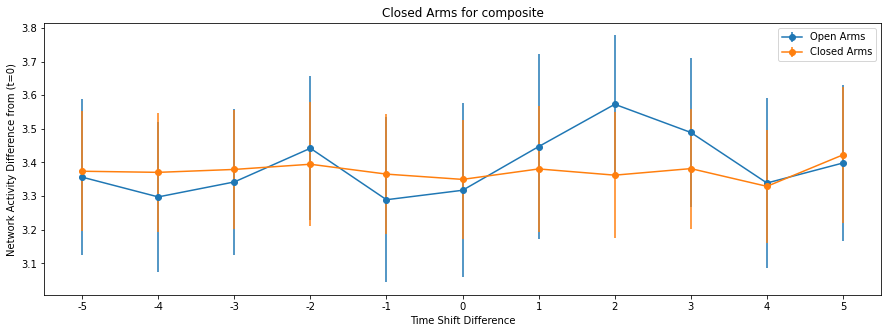

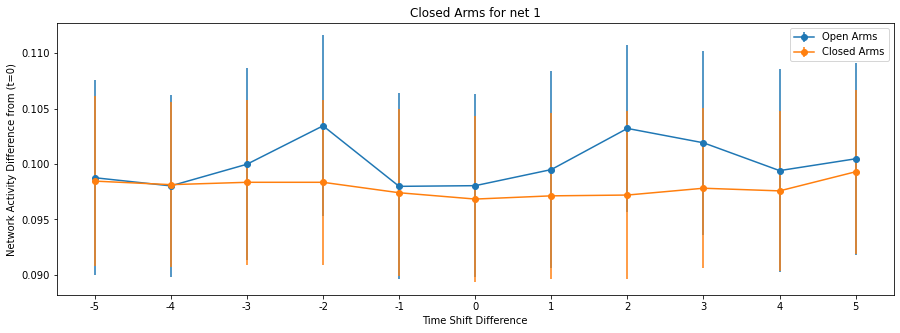

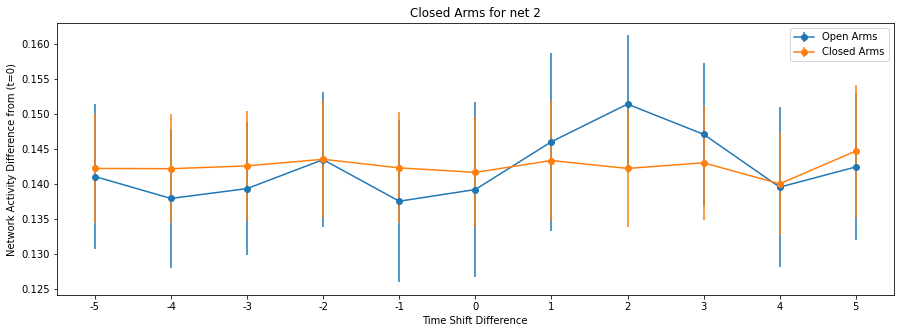

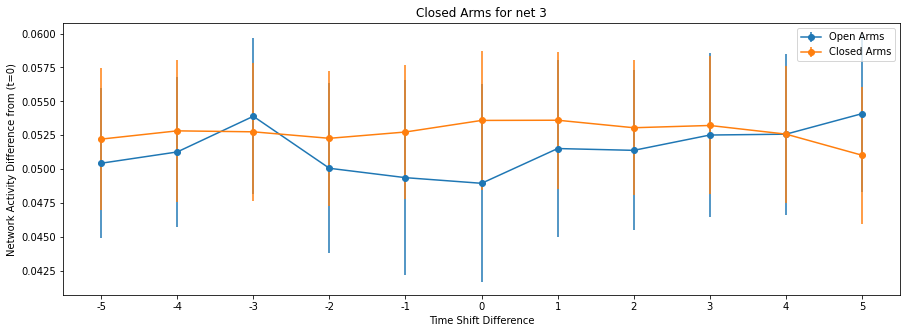

,mouse,geno,location,network,mean task score,mean hc score,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,Mouse0911,WT,oa,composite,4.192368,3.339579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mouse0912,CLOCK,oa,composite,2.190489,2.407074,2.122172,2.143992,2.030888,2.593185,2.314741,2.050043,2.119494,2.235314,1.702768,1.863544,2.182114
2,Mouse0913,CLOCK,oa,composite,3.589009,2.714567,3.283763,3.407528,3.444773,3.556086,3.574477,3.821771,3.793555,3.806427,3.712394,3.602514,3.619014
3,Mouse0914,WT,oa,composite,4.458719,3.481134,5.247053,4.816639,4.720728,4.982831,5.09919,5.05618,5.395213,5.368576,5.196635,4.600516,4.549769
4,Mouse2401,CLOCK,oa,composite,3.318642,3.535969,3.180351,2.812974,2.80685,2.893363,3.564067,3.562291,3.545544,3.717598,4.142781,2.635707,4.339615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,Mouse69841,CLOCK,ca,net 3,0.034818,0.037393,0.037551,0.037746,0.037776,0.038665,0.038956,0.038179,0.038283,0.038253,0.037409,0.038584,0.035494
38,Mouse69861,WT,ca,net 3,0.031028,0.029201,0.031416,0.031339,0.031276,0.030672,0.031072,0.030622,0.030812,0.030874,0.030651,0.030787,0.03049
39,Mouse69862,WT,ca,net 3,0.038106,0.041945,0.036917,0.036978,0.037971,0.037724,0.037605,0.037881,0.038159,0.036776,0.037237,0.037928,0.036235
40,Mouse69872,CLOCK,ca,net 3,0.037093,0.043621,0.036389,0.036043,0.036735,0.037545,0.03755,0.036648,0.037009,0.036574,0.035519,0.034709,0.035503


In [24]:
sliding_avg_size=5

allMice_oa_means = []
allMice_ca_means = []

allDiffs_oa = []
allDiffs_ca = []
for mouse in np.unique(df_in_task.mouse):
    
    #print(mouse)
    mouse_mask = df_in_task.mouse==mouse
    nan_filter = 1-np.isnan(df_in_task.roi)
    mask = np.logical_and(mouse_mask,nan_filter)
    
    in_open_arms = np.logical_or(df_in_task[mask==1]["roi"].values==2,
                                 df_in_task[mask==1]["roi"].values==4)
    
    in_closed_arms = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                                   df_in_task[mask==1]["roi"].values==3)
    
    mouse_time = df_in_task[mask==1]["time"].values
    mouse_roi = df_in_task[mask==1]["roi"].values
    
    nagg_s = df_in_task[mask==1]["agg score"].values
    n1_s = df_in_task[mask==1]["net 1 scores"].values
    n2_s = df_in_task[mask==1]["net 2 scores"].values
    n3_s = df_in_task[mask==1]["net 3 scores"].values
    
    mouse_oa_avgs = []
    mouse_ca_avgs = []
    mouse_avgs = []
    
    oa_centers = []
    ca_centers = []
    all_times = []
    for idx, roi in enumerate(mouse_roi):
        if idx > sliding_avg_size and idx < (len(mouse_roi) - sliding_avg_size):
            
            nagg_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n1_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n2_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            n3_slice = np.zeros(sliding_avg_size*2 + 1)*np.nan
            
            center_time = mouse_time[idx]
            start_time = center_time - sliding_avg_size
            end_time = center_time + sliding_avg_size
            cont_time = np.arange(start_time,end_time+1)
            
            actual_time = mouse_time[idx-sliding_avg_size:idx+sliding_avg_size+1]
            
            actual_nagg_scores = nagg_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n1_scores = n1_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n2_scores = n2_s[idx-sliding_avg_size:idx+sliding_avg_size+1]
            actual_n3_scores = n3_s[idx-sliding_avg_size:idx+sliding_avg_size+1]

            for i,time in enumerate(cont_time):
                if time in actual_time:
                    temp_mask = actual_time==time
                    nagg_slice[i] = actual_nagg_scores[temp_mask==1][0]
                    n1_slice[i] = actual_n1_scores[temp_mask==1][0]
                    n2_slice[i] = actual_n2_scores[temp_mask==1][0]
                    n3_slice[i] = actual_n3_scores[temp_mask==1][0]
                    
            slice_means = [nagg_slice,
                           n1_slice,
                           n2_slice,
                           n3_slice]
            
            all_times.append(center_time)
            mouse_avgs.append(np.array(slice_means))
            #if in the open arms
            if roi==2 or roi==4: 
                mouse_oa_avgs.append(slice_means)
                oa_centers.append(center_time)
            #if in the closed arms
            elif roi==1 or roi==3: 
                mouse_ca_avgs.append(slice_means)
                ca_centers.append(center_time)
            
    if len(mouse_oa_avgs) >0:
        mouse_oa_slice_mean = np.nanmean(mouse_oa_avgs,axis=0)
    else:
        mouse_oa_slice_mean = np.zeros((4,11))*np.nan
    mouse_ca_slice_mean = np.nanmean(mouse_ca_avgs,axis=0)
    
    #print(len(mouse_oa_avgs))
    allMice_oa_means.append(mouse_oa_slice_mean)
    allMice_ca_means.append(mouse_ca_slice_mean)
    
    
allMice_oa_means = np.array(allMice_oa_means)
allMice_ca_means = np.array(allMice_ca_means)

df_list = []
for i, net in zip(range(4),["composite","net 1","net 2","net 3"]):
    
    plt.figure(figsize=(15,5))
    #shared_meanish = np.nanmean(allMice_oa_means,axis=0)[i][5] / 2 + np.nanmean(allMice_ca_means,axis=0)[i][5] / 2
    #plt.subplot(1,2,1)
    oa_mean = np.nanmean(allMice_oa_means,axis=0)
    oa_stderr = np.nanstd(allMice_oa_means,axis=0) / np.sqrt(11)

    plt.errorbar(np.arange(11),oa_mean[i,:],yerr=oa_stderr[i,:],fmt="-o", label="Open Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Open Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    #plt.subplot(1,2,2)
    ca_mean = np.nanmean(allMice_ca_means,axis=0)
    ca_stderr = np.nanstd(allMice_ca_means,axis=0) / np.sqrt(11)

    plt.errorbar(np.arange(11),ca_mean[i,:],yerr=ca_stderr[i,:],fmt="-o", label="Closed Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Closed Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()
    
    ctr_surr_mat = np.vstack([allMice_oa_means[:,i,:],
                              allMice_ca_means[:,i,:]])
    mice = np.vstack([np.unique(df_in_task.mouse).reshape(-1,1),
                      np.unique(df_in_task.mouse).reshape(-1,1)])
    
    geno = np.vstack([np.array([geno_map[mouse] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1),
                      np.array([geno_map[mouse] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1)])
    
    mean_net_intask_scores = np.vstack([np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgTaskScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1),
                                       np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgTaskScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1)])
    
    mean_net_hc_scores = np.vstack([np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgHCScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1),
                                       np.array([df_mean_scores[df_mean_scores.mouse==mouse]["{} avgHCScore".format(net)] for mouse in np.unique(df_in_task.mouse)]).reshape(-1,1)])
    #mean_net_surr_scores = np.vstack([mean_oa_scores[i,:].reshape(-1,1),
    #                                  mean_ca_scores[i,:].reshape(-1,1)])
    
    ctr_vs_surr = np.hstack([["oa" for _ in range(21)],
                             ["ca" for _ in range(21)]]).reshape(-1,1)
    
    net_number = np.hstack([[net for _ in range(21)],
                             [net for _ in range(21)]]).reshape(-1,1)
    
    saveData = np.hstack([mice,geno,ctr_vs_surr,net_number,mean_net_intask_scores,mean_net_hc_scores,ctr_surr_mat]).astype(object)
    
    df_saveData = pd.DataFrame(saveData,
                               columns = ["mouse","geno","location","network","mean task score","mean hc score"] + list(np.arange(-5,6).astype(str)))
    
    df_list.append(df_saveData)
    
df_complete = pd.concat(df_list)
df_complete.to_csv(PROJECT_PATH + "headstage_tracked_0s_filterd_CLOCK_BalbC_EPM_11s_slice_data.csv")
df_complete

In [35]:
wt_oa_norm_scores.shape[0]

10

In [40]:
np.sum(1-np.isnan(wt_oa_norm_scores[:,0]))

9

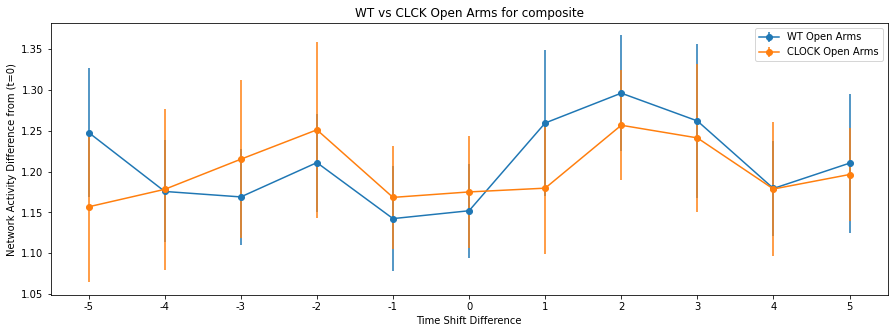

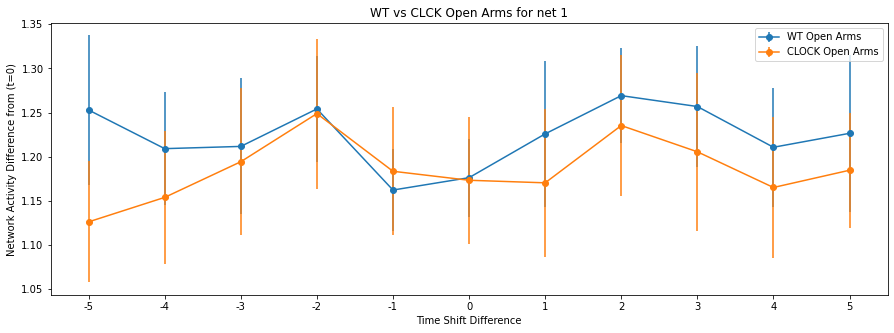

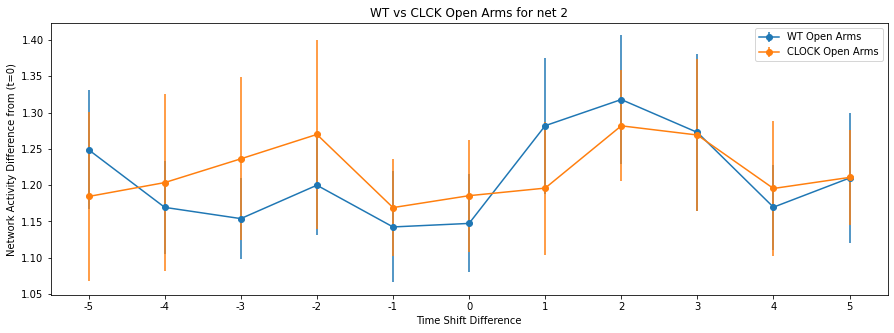

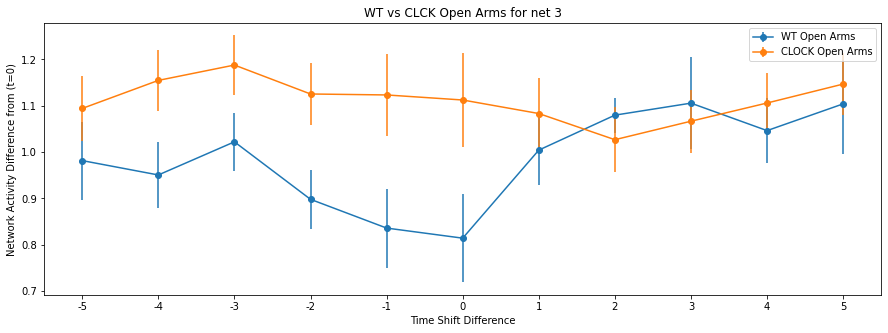

In [44]:
for net in ["composite","net 1","net 2","net 3"]:
    net_mask = df_complete.network==net
    
    oa_mask = np.logical_and(net_mask,df_complete.location=="oa")
    ca_mask = np.logical_and(net_mask,df_complete.location=="ca")
    
    wt_mask = df_complete.geno == "WT"
    clck_mask = df_complete.geno=="CLOCK"
    
    oa_wt_mask = np.logical_and(oa_mask,wt_mask)
    oa_clck_mask = np.logical_and(oa_mask,clck_mask)
    
    ca_wt_mask = np.logical_and(ca_mask,wt_mask)
    ca_clck_mask = np.logical_and(ca_mask,clck_mask)
    
    wt_oa_norm_scores = df_complete[oa_wt_mask==1][list(np.arange(-5,6).astype(str))].values / df_complete[oa_wt_mask==1]["mean hc score"].values.reshape(-1,1)
    clck_oa_norm_scores = df_complete[oa_clck_mask==1][list(np.arange(-5,6).astype(str))].values / df_complete[oa_clck_mask==1]["mean hc score"].values.reshape(-1,1)
    
    wt_oa_norm_scores=wt_oa_norm_scores.astype(float)
    clck_oa_norm_scores=clck_oa_norm_scores.astype(float)
    
    wt_oa_mean_score = np.nanmean(wt_oa_norm_scores,axis=0)
    wt_oa_stderr_score = np.nanstd(wt_oa_norm_scores,axis=0) / np.sqrt(np.sum(1-np.isnan(wt_oa_norm_scores[:,0])))
    
    clck_oa_mean_score = np.nanmean(clck_oa_norm_scores,axis=0)
    clck_oa_stderr_score = np.nanstd(clck_oa_norm_scores,axis=0) / np.sqrt(np.sum(1-np.isnan(clck_oa_norm_scores[:,0])))
    
    plt.figure(figsize=(15,5))
    
    plt.errorbar(np.arange(11),wt_oa_mean_score,yerr=wt_oa_stderr_score,fmt="-o", label="WT Open Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("Open Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")

    plt.errorbar(np.arange(11),clck_oa_mean_score,yerr=clck_oa_stderr_score,fmt="-o", label="CLOCK Open Arms")
    plt.xticks(np.arange(11), np.arange(11)-5)
    plt.title("WT vs CLCK Open Arms for {}".format(net))
    plt.ylabel("Network Activity Difference from (t=0)")
    plt.xlabel("Time Shift Difference")
    plt.legend()
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice


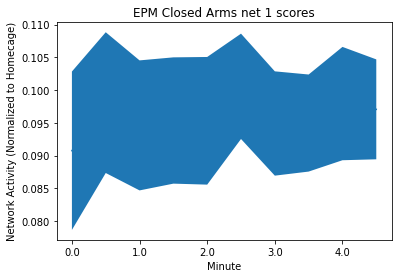

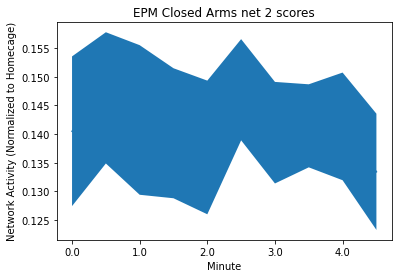

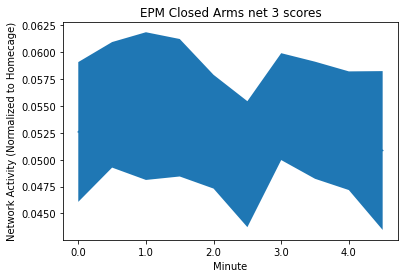

In [29]:
max_size = 300
n_mice = 21
network_score_matrices = []
for net_type in ["net 1 scores","net 2 scores", "net 3 scores"]:
    score_matrix = np.zeros((np.unique(df_in_task.mouse).shape[0],max_size)) * np.nan
    mouse_hc_mean_scores = []
    mouse_geno_list = []
    for idx,mouse in enumerate(np.unique(df_in_task.mouse)):
        geno = df_in_task[df_in_task.mouse==mouse].condition.values[0]
        mouse_geno_list.append(geno)
        mouse_mask = df_in_task.mouse==mouse
        mouse_start_time = np.min(df_in_task[mouse_mask==1].time)
        mouse_max_time = mouse_start_time + max_size
        time_mask = np.logical_and(df_in_task.time >= mouse_start_time, df_in_task.time < mouse_max_time)
        mask= np.logical_and(mouse_mask,time_mask)
        
        closed_arms = np.logical_or(df_in_task[mask==1]["roi"].values==1,
                                    df_in_task[mask==1]["roi"].values==3)
        drop_mask = 1 - closed_arms
        
        nan_mask = np.ones(closed_arms.shape)
        nan_mask[drop_mask==1]=np.nan
        
        
        scores = df_in_task[mask==1][net_type]*nan_mask #/ np.nanmean(df_in_hc[df_in_hc.mouse==mouse][net_type])
        times = df_in_task[mask==1].time - df_in_task[mask==1].time.values[0]
        mouse_hc_mean_scores.append(np.nanmean(df_in_hc[df_in_hc.mouse==mouse][net_type].values))
        keep_scores = []
        for time in range(max_size):
            if time in list(times):
                score_idx = np.where(times==time)[0][0]
                keep_scores.append(scores.values[score_idx])
            else:
                keep_scores.append(np.nan)
                
        keep_scores = np.array(keep_scores)
        
        #keep_scores = [scores[np.where(times==time)[0][0]] if time in times else np.nan for time in range(300)]
        
        score_matrix[idx,:] = keep_scores
        
    saveMat = np.hstack([np.unique(df_in_task.mouse).reshape(-1,1),
                         np.array(mouse_geno_list).reshape(-1,1),
                         np.array(mouse_hc_mean_scores).reshape(-1,1),
                         score_matrix]).astype(object)
    df_temp = pd.DataFrame(saveMat,
                           columns = ["mouse","geno","HC_mean_scores"] + list(np.arange(1,301).astype(str)))
    network_score_matrices.append(df_temp)
    df_temp.to_csv(PROJECT_PATH + "_".join(net_type.split(" ")) + "_headstage_tracked_CD19EPM_closed_arm_scores_over_time_w_HC_mean.csv")
    second_averages = 30
    mean = np.nanmean(np.nanmean(score_matrix.reshape(n_mice,-1,second_averages),axis=2),axis=0)
    sterr = np.nanstd(np.nanmean(score_matrix.reshape(n_mice,-1,second_averages),axis=2),axis=0) / np.sqrt(9)
    plt.plot(mean)
    plt.fill_between(range(int(max_size/second_averages)),mean + sterr, mean - sterr)
    
    #plt.xticks(np.arange(int(max_size/second_averages)), np.arange(0,max_size,int(max_size/second_averages)))
    plt.title("EPM Closed Arms "+net_type)
    plt.ylabel("Network Activity")
    plt.xlabel("Network Activity")
    plt.xticks(np.arange(0,10,2),np.arange(0,10,2)*30/60)
    plt.xlabel("Minute")
    plt.ylabel("Network Activity (Normalized to Homecage)")
    #plt.ylim([1.2,2.2])
    plt.show()